In [1]:
import torch
from torch import nn
import torch.nn.functional as F # lossfunction
import torch.optim as optim # optimization (cnovex and non convex)
from torchinfo import summary 

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt 
import numpy as np
import random; import time 


In [2]:
# seed has something to do with the number of runtimes when are running whole notebook. It stops the functions and network from reinitializing of the random numbers generated

In [3]:
def set_seeds():
    seed_value = 42

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available(): # controls the randomness in the gpu
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()


In [4]:
#the important note is that by applying subtracting the mean and dividing the standard deviation from the all the pixels, they normalized and centred at zero

raw_transform = transforms.Compose([transforms.ToTensor()])
train_set_raw = datasets.FashionMNIST(root = "F_MNIST_data",download = True, train = True, transform = raw_transform)

all_pixels = torch.cat([img.view(-1) for img, _ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"mean is :{mean:.4f},deviation is :{std:.4f}")



mean is :0.2860,deviation is :0.3530


In [5]:
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((mean),(std))])

train_set = datasets.FashionMNIST(root= "F_MNIST_data",download =True,train= True,transform=transform)
val_set = datasets.FashionMNIST(root= "F_MNIST_data",download =True,train= False,transform=transform)

print("number of train images",len(train_set))
print("number of test images",len(val_set))

number of train images 60000
number of test images 10000


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size= 64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle = False, batch_size= 64)


In [7]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

Data Visualisation

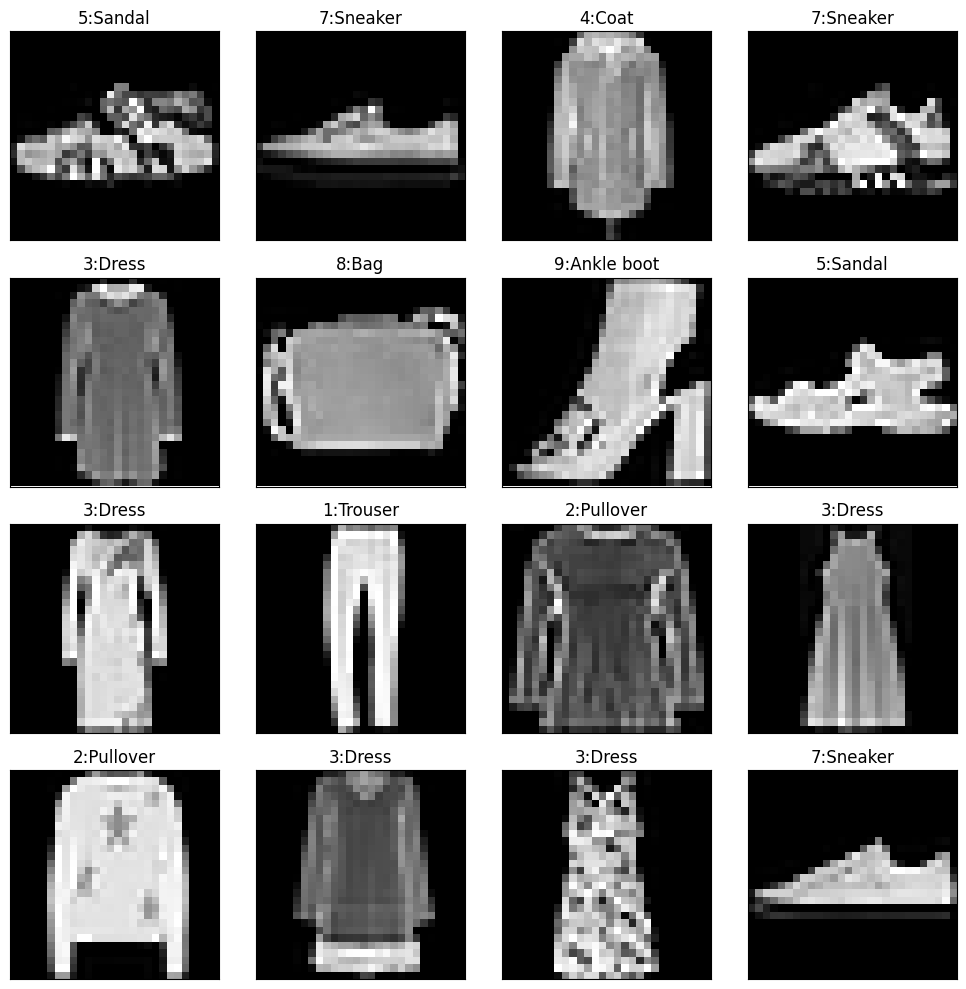

In [8]:
def image_visualisation(trainloader, num_images= 20):
    fig = plt.figure(figsize=(10,10))

    images, labels = next(iter(trainloader))
    num_rows = 4
    num_cols = int(np.ceil(num_images/num_rows))

    for idx in range(min(num_images,len(images))):
        image, label = images[idx],labels[idx]

        ax = fig.add_subplot(num_rows,num_cols,idx+1,xticks=[], yticks=[])
        ax.imshow(np.squeeze(image),cmap= "gray")
        ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

image_visualisation(train_loader, num_images = 16)




In [9]:
class MultiLP(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.fc0 = nn.Linear(784,512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128,64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64,num_classes)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.fc4(x),dim=1)

        return x
    


mlp_model = MultiLP(num_classes=10)





In [10]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))
# Display the model summary.

Layer (type (var_name))                  Output Shape              Param #
MultiLP (MultiLP)                        [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

Train COnfig

In [11]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)
num_epochs = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
 

Model Training

In [12]:
def train(model, train_loader, criterion, optimizer, DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images,labels in train_loader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss +=loss.item()
        _, predicted = torch.max(outputs.data,dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted==labels).sum().item()

    avg_loss = running_loss/len(train_loader)
    accuracy = 100*correct_predictions/total_samples
    return avg_loss, accuracy    


In [13]:
def validation(model, val_loader, criterion, DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss=0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss+=loss.item()
            _,predicted = torch.max(outputs.data,1)
            total_samples +=labels.size(0)
            correct_predictions+=(predicted==labels).sum().item()
    
    avg_loss = running_loss/len(val_loader)
    accuracy = 100*correct_predictions/total_samples
    return avg_loss,accuracy



In [14]:
def main(model,train_loader,val_loader,epochs=5,DEVICE = "cuda"):
# with every epoch, that is the complete cycle of the 
    train_losses, val_losses = [],[]
    train_accuracies,val_accuracies = [],[]

    for epoch in range(epochs):

        train_loss, train_accuracy = train(model, train_loader,criterion,optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()        



Epoch 01/20 - Train Loss: 0.5598, Train Accuracy: 80.09% - Val Loss: 0.4378, Val Accuracy: 84.07%
Epoch 02/20 - Train Loss: 0.4395, Train Accuracy: 84.34% - Val Loss: 0.3778, Val Accuracy: 85.83%
Epoch 03/20 - Train Loss: 0.3958, Train Accuracy: 86.00% - Val Loss: 0.3782, Val Accuracy: 85.95%
Epoch 04/20 - Train Loss: 0.3739, Train Accuracy: 86.48% - Val Loss: 0.3597, Val Accuracy: 86.68%
Epoch 05/20 - Train Loss: 0.3550, Train Accuracy: 87.26% - Val Loss: 0.3361, Val Accuracy: 87.69%
Epoch 06/20 - Train Loss: 0.3405, Train Accuracy: 87.69% - Val Loss: 0.3458, Val Accuracy: 87.52%
Epoch 07/20 - Train Loss: 0.3281, Train Accuracy: 88.06% - Val Loss: 0.3236, Val Accuracy: 88.24%
Epoch 08/20 - Train Loss: 0.3138, Train Accuracy: 88.56% - Val Loss: 0.3243, Val Accuracy: 88.23%
Epoch 09/20 - Train Loss: 0.3031, Train Accuracy: 89.04% - Val Loss: 0.3118, Val Accuracy: 88.78%
Epoch 10/20 - Train Loss: 0.2958, Train Accuracy: 89.21% - Val Loss: 0.3282, Val Accuracy: 88.38%
Epoch 11/20 - Train 

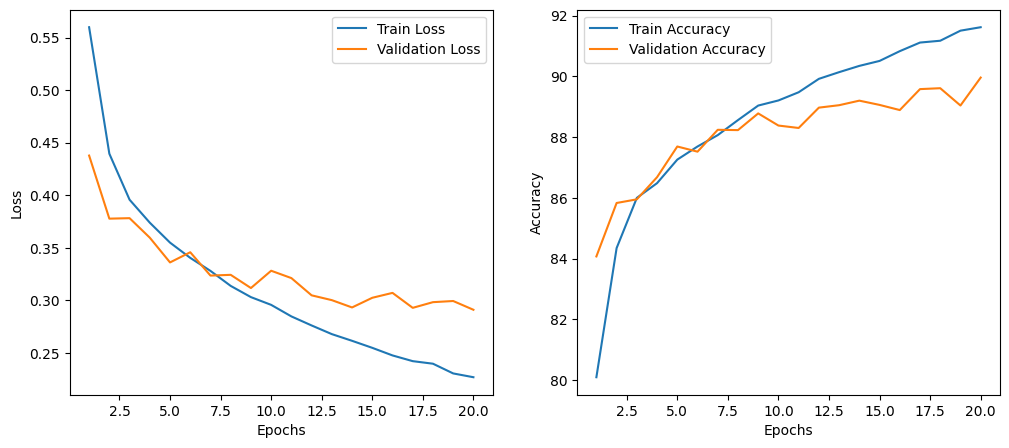

In [15]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [19]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1) #along num of classes dimension

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

In [20]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

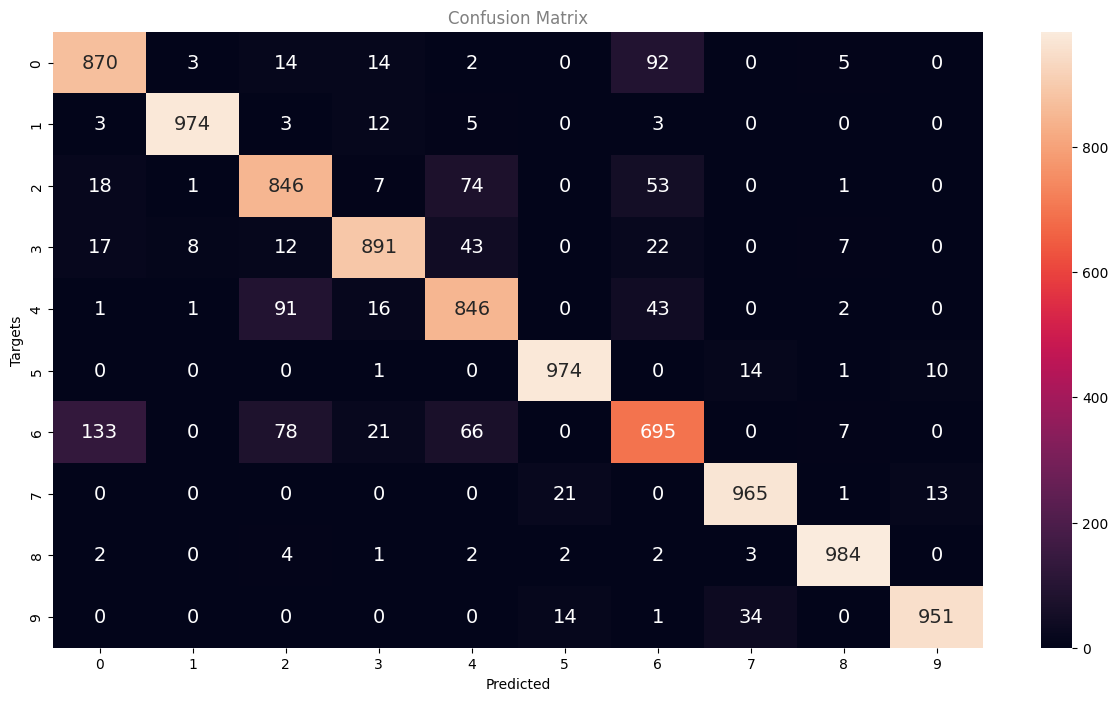

In [21]:
cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])

# Plot the confusion matrix as a heatmap.
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()